![Logo ITESO](./Data/Imagenes/logo.png)
# Examen Final
### Materia: Proyecto de Ciencia de Datos
#### José Manuel Haces López - 734759 - Ing. Y Ciencia de Datos - ITESO
_______

#### Descripción de la Base de Datos
<p>En escuelas de E.U.A los maestros desarrollan proyectos para mejorar las condiciones de los estudiantes, resolver problemáticas como el bullying, mejorar el prendizaje, etc. El dataset <b>Projects_cleansed.zip</b> esta formado por las siguientes columnas:<br>
</p>

<b>Project Title</b> - Nombre del Proyecto<br>
<b>Project Short Description </b> - Descripción corta (198 palabras aprox.) y el final de la descripción esta indicada por "..."<br>
<b>Project Subject Category Tree</b> - es una taxonomía que indica el área al que pertenece el proyecto<br>
    <b>Project Cost</b> - es un campo numérico que indica la cantidad que se busca fondear<br>
    <b>Project Current Status</b> - Si el proyecto fué fondedado o no<br>

_______
#### Instrucciones:
1. Análisis Exploratorio de Datos.
2. Ingeniería de Características - Data Wrangling
3. Entrenamiento, validación, evaluación y selección del modelo
4. Micro-Servicio (API) para servir el modelo
5. Creación de imagen para dicha API. Explicar el procedimiento utilizado para crear la imagen y correr el contenedor. (Adjunte imagenes como prueba del funcionamiento del contenedor de la API)

In [1]:
# Librerías
import re
import keras
import pickle
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

warnings.filterwarnings('ignore')

## 0. Carga de Datos

In [2]:
# Cargando el Archivo CSV
df = pd.read_csv(r'./Data/Projects_cleansed.csv')
df.head()

,Project Title,Project Short Description,Project Subject Category Tree,Project Cost,Project Current Status
0,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,Applied Learning,361.80,Fully Funded
1,Learning in Color!,"Help us have a fun, interactive listening cent...","Applied Learning, Literacy & Language",512.85,Expired
2,Help Second Grade ESL Students Develop Languag...,Visiting or moving to a new place can be very ...,Literacy & Language,435.92,Fully Funded
3,Help Bilingual Students Strengthen Reading Com...,Students at our school are still working hard ...,Literacy & Language,161.26,Fully Funded
4,Help Us Make Each Minute Count!,"""Idle hands"" were something that Issac Watts s...",Special Needs,264.19,Fully Funded


## 1. Análisis Exploratorio

In [3]:
# Imprimiendo las dimensiones de nuestra matriz
print(f'Contamos con: \n- {df.shape[0]} filas. \n- {df.shape[1]} columnas/variables.')

Contamos con: 
- 1109981 filas. 
- 5 columnas/variables.


- De las cuales 4 son variables Independientes:
    - Project Title
    - Project Short Description
    - Project Subject Category Tree
    - Project Cost

- Nuestra variable dependiente es:
    - Project Current Status


In [4]:
# Tipos de datos que tenemos
df.dtypes

Project Title                     object
Project Short Description         object
Project Subject Category Tree     object
Project Cost                     float64
Project Current Status            object
dtype: object

Tenemos:
- 3 variables independientes que son cadenas de texto.
- 1 variable independiente que es flotante (decimal).
- 1 Variable dependiente/respuesta que es una cadena de texto.

In [5]:
# Estadísticos de la Variable de numérica
df.describe()

,Project Cost
count,1.109981e+06
mean,7.415194e+02
std,1.083264e+03
min,3.529000e+01
25%,3.351200e+02
50%,5.153500e+02
75%,8.675100e+02
max,2.557377e+05


In [6]:
# Sacando el número de valores únicos por variable
for i in df.columns:
    print(f'- {i} tiene {len(df[i].unique())} valores únicos.')

- Project Title tiene 926099 valores únicos.
- Project Short Description tiene 841865 valores únicos.
- Project Subject Category Tree tiene 51 valores únicos.
- Project Cost tiene 163022 valores únicos.
- Project Current Status tiene 3 valores únicos.


- Con esto podemos ver que tenemos dos variables categóricas en nuestro dataset:
    - Project Subject Category Tree
    - Project Current Status


In [7]:
cat = ['Project Subject Category Tree', 'Project Current Status']

for i in cat:
    print(df.value_counts(i))
    print('\n')

Project Subject Category Tree
Literacy & Language                           250504
Math & Science                                172515
Literacy & Language, Math & Science           153967
Music & The Arts                               56828
Health & Sports                                48690
Applied Learning                               44991
Literacy & Language, Special Needs             41308
Special Needs                                  35554
Applied Learning, Literacy & Language          31144
Math & Science, Literacy & Language            27956
Literacy & Language, Music & The Arts          21175
History & Civics                               20545
Applied Learning, Special Needs                20478
Math & Science, Special Needs                  18712
History & Civics, Literacy & Language          18639
Math & Science, Music & The Arts               16890
Math & Science, Applied Learning               15407
Applied Learning, Math & Science               12962
Literacy & Langu

In [8]:
# Número de NaN en nuestro Dataset
df.isna().sum()

Project Title                    0
Project Short Description        0
Project Subject Category Tree    0
Project Cost                     0
Project Current Status           0
dtype: int64

## 2. Ingeniería de Características / Data Wrangling
### 2.1. Eliminando Outliers de la Variable 'Project Cost'
- Como pudimos ver en los estadísticos de la variable, tenemos valores muy grandes que nos van a generar ruido, por lo que lo mejor será eliminarlos o cambiarlos.

<AxesSubplot:>

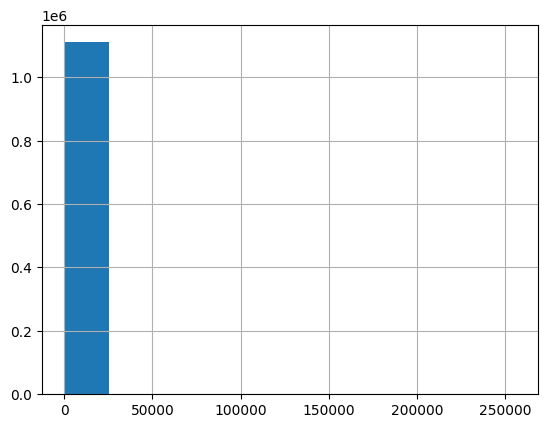

In [9]:
# Histograma de la variable numérica
df['Project Cost'].hist()

In [10]:
# Calculando el Percentil 99.5 para la variable, es decir, tomar el 99.5% de los datos
# Se deja fuera el 0.5% de los últimos datos.
p99 = np.percentile(df['Project Cost'], 99.5)
print(f'El límite superior será de: {np.round(p99, decimals=2)}')

# Eliminando los outliers, todo lo que sea mayor al valor del percentil
outliers = df[df['Project Cost'] > p99]
print(f'Se eliminarán {len(outliers)} filas.')

# Creando el Df sin Outliers
df = df[df['Project Cost'] < p99]
print(f'Len del Df sin Outliers es de {len(df)} filas.')

El límite superior será de: 5137.7
Se eliminarán 5550 filas.
Len del Df sin Outliers es de 1104431 filas.


### 2.2. Encoding de Variables Categóricas
Nuestras variables categóricas son:
- Project Subject Category Tree (Independiente)
- Project Current Status (Dependiente)

#### 2.2.1. Cambiando variable 'Project Current Status'

In [11]:
# Viendo la cantidad de datos por categoría
df['Project Current Status'].value_counts()

Fully Funded    823969
Expired         239051
Live             41411
Name: Project Current Status, dtype: int64

- Asumiremos que 'Live' y 'Fully Founded' son las categorías para los que sí fondearon, por lo que los juntaremos en la misma etiqueta (1).
- Por lo que 'Expired' tendrá la etiqueta de los no fondeados (0).

In [12]:
# Diccionario donde están los cambios para las etiquetas
var_resp_dic = {
    'Fully Funded': 1,
    'Live': 1,
    'Expired': 0
    }

# Haciendo el cambio a la variable
df['Project Current Status'].replace(var_resp_dic, inplace=True)
df['Project Current Status'].value_counts()

1    865380
0    239051
Name: Project Current Status, dtype: int64

#### 2.2.2. Cambiando variable 'Project Subject Category Tree'

In [13]:
# Creando un vector con el porcentaje de Frecuencia por categoría
freq = df.groupby('Project Subject Category Tree').size() / len(df)

# Creando la variable y mapeando el cambio
df.loc[:, 'Project Subject Category Tree Freq'] = df['Project Subject Category Tree'].map(freq)

# Mostrando los resultados
df[['Project Subject Category Tree Freq', 'Project Subject Category Tree']].value_counts()

Project Subject Category Tree Freq  Project Subject Category Tree             
0.226315                            Literacy & Language                           249949
0.155057                            Math & Science                                171250
0.138853                            Literacy & Language, Math & Science           153354
0.051096                            Music & The Arts                               56432
0.043795                            Health & Sports                                48369
0.040505                            Applied Learning                               44735
0.037294                            Literacy & Language, Special Needs             41189
0.032130                            Special Needs                                  35485
0.028057                            Applied Learning, Literacy & Language          30987
0.025173                            Math & Science, Literacy & Language            27802
0.019112                       

In [14]:
a = df[['Project Subject Category Tree Freq', 'Project Subject Category Tree']].value_counts().reset_index()
a = a[['Project Subject Category Tree', 'Project Subject Category Tree Freq']]

dict_trans = dict(a.values)
dict_trans

{'Literacy & Language': 0.22631472676880673,
 'Math & Science': 0.15505721950941254,
 'Literacy & Language, Math & Science': 0.13885340052932235,
 'Music & The Arts': 0.0510959942268915,
 'Health & Sports': 0.04379540233839869,
 'Applied Learning': 0.04050502023213763,
 'Literacy & Language, Special Needs': 0.037294317164223025,
 'Special Needs': 0.032129666769585424,
 'Applied Learning, Literacy & Language': 0.028056981377741118,
 'Math & Science, Literacy & Language': 0.025173143455770437,
 'Literacy & Language, Music & The Arts': 0.019112103879735356,
 'Applied Learning, Special Needs': 0.01847829334743411,
 'History & Civics': 0.01841672318143913,
 'Math & Science, Special Needs': 0.016827669632598144,
 'History & Civics, Literacy & Language': 0.016754328699574713,
 'Math & Science, Music & The Arts': 0.015228656203963851,
 'Math & Science, Applied Learning': 0.013775419197758846,
 'Applied Learning, Math & Science': 0.011627706936875187,
 'Literacy & Language, History & Civics': 0

In [15]:
# Exportando el modelo
pickle.dump(dict_trans, open(r'./Modelos/Dict_trans.pkl', 'wb'))

### 2.3. Limpiando Texto de variable 'Project Short Description'

In [16]:
# Creando una columna con el texto limpio de caracteres
df["Project Short Description Cleaned"] = df['Project Short Description'].apply(
    lambda txt: re.sub(
        r"[\W\d\s\.+]", # Quitando los caracteres especiales, números, más de un espacio y más de 1 punto (.)
        ' ', # Replace con nada
        txt.lower() # Poniendo en minúsculas
    )
)

# Quitando espacios extras y dejando solo 1
df["Project Short Description Cleaned"] = df['Project Short Description Cleaned'].apply(
    lambda txt: re.sub(
        ' +',
        ' ',
        txt)
)

df[['Project Short Description', 'Project Short Description Cleaned']].head()

,Project Short Description,Project Short Description Cleaned
0,Did you know that 1-7 students in grades K-12 ...,did you know that students in grades k is eith...
1,"Help us have a fun, interactive listening cent...",help us have a fun interactive listening cente...
2,Visiting or moving to a new place can be very ...,visiting or moving to a new place can be very ...
3,Students at our school are still working hard ...,students at our school are still working hard ...
4,"""Idle hands"" were something that Issac Watts s...",idle hands were something that issac watts sp...


### 2.4. Cambiando Nombre de Columnas
- Este paso solo se hace para Facilitar el uso de las columnas

In [17]:
# Lista con las columnas originales
cols = list(df.columns)

# Ciclo para cambiar las columnas
for i in range(len(cols)):
    col = cols[i]
    col = col.replace(' ', '_')
    cols[i] = col

# Cambiando el nombre de las columnas
df.columns = cols
df.columns

Index(['Project_Title', 'Project_Short_Description',
       'Project_Subject_Category_Tree', 'Project_Cost',
       'Project_Current_Status', 'Project_Subject_Category_Tree_Freq',
       'Project_Short_Description_Cleaned'],
      dtype='object')

### 2.5. Convirtiendo de Texto a Vector
- Este paso se hace para poder ingresar la descripción del proyecto al modelo

In [18]:
# Cargando corpus de stopwords en inglés
stopwrds = stopwords.words('english')

# Creando el objeto vectorizador
vectorizer = CountVectorizer(max_features=200,
                             min_df=3,
                             max_df=0.75,
                             stop_words=stopwrds
                             )

# Creando el BOW (Bag Of Words) con el vectorizador
bow = vectorizer.fit_transform(df['Project_Short_Description']).toarray()

In [19]:
# Exportando el modelo
pickle.dump(vectorizer, open(r'./Modelos/Vectorizer.pkl', 'wb'))

In [20]:
# Creando el Objeto para TF-IDF
transformer = TfidfTransformer()
# Entrenando el transformer
transformer = transformer.fit(bow)

# Ejecutando la transformación
my_tfidf = transformer.fit_transform(bow).toarray()
my_tfidf = pd.DataFrame(my_tfidf)
my_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.346706,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.19601,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Exportando el modelo
pickle.dump(transformer, open(r'./Modelos/TfIdf_Model.pkl', 'wb'))

### 2.6. Creando Dataset Final
- Se tomarán las nuevas variables limpias y se eliminará el título, ya que se tomó la decisión de que el description engloba el mismo.

In [27]:
# Tomando las variables creadas en este apartado
df_nuevo = df[['Project_Current_Status', 'Project_Cost', 'Project_Subject_Category_Tree_Freq']]

# Uniendo las variables seleccionadas y la vectorización del description en el dataset final
df_final = pd.concat([df_nuevo, my_tfidf], axis=1)
df_final = df_final.astype(float)
df_final.dropna(inplace=True)
df_final.head()

,Project_Current_Status,Project_Cost,Project_Subject_Category_Tree_Freq,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,1.0,361.80,0.040505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,512.85,0.028057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,435.92,0.226315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,161.26,0.226315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.346706,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,264.19,0.032130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.19601,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### 2.7. Normalizando Dataset Final

In [28]:
# Vector con la variable de respuesta
y = df_final['Project_Current_Status']

# Creando el objeto para normalizar
norm = MinMaxScaler()
# Entrenando y transformando
df_esc = df_final.drop('Project_Current_Status', axis=1)
scaled_df_final = norm.fit_transform(df_esc)
scaled_df_final = pd.DataFrame(scaled_df_final)
scaled_df_final = pd.concat([y, scaled_df_final], axis=1)
scaled_df_final.head()

,Project_Current_Status,0,1,2,3,4,5,6,7,8,...,192,193,194,195,196,197,198,199,200,201
0,1.0,0.063992,0.178960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.093596,0.123956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.078518,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.024689,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.346706,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.044862,0.141952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.19601,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Exportando el modelo de noramlización
pickle.dump(norm, open(r'./Modelos/Norm_Model.pkl', 'wb'))

### 2.8. Separando en Train y Test

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    scaled_df_final.drop('Project_Current_Status', axis=1),
    scaled_df_final['Project_Current_Status'],
    train_size=0.8,
    random_state=42)

print(f'Long Train: {len(X_train)}. \nLong Test: {len(X_test)}.')

Long Train: 883515. 
Long Test: 220879.


## 3. Modelo
### 3.1. Regresión Logística

In [21]:
# Creando el Modelo
model_lr = LogisticRegression()

# Entrenando el Modelo
model_lr.fit(X_train, y_train)

# Predienciendo con nuestro Modelo
y_pred = model_lr.predict(X_test)

# Evaluamos qué tan bueno es nuestro modelo con una matriz de confusión
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[  3492,  44071],
       [  3832, 168390]], dtype=int64)

In [22]:
# Accuracy de nuestro modelo (TP+TN/4)
np.round(model_lr.score(X_test, y_test), decimals=4)

0.782

In [26]:
# Exportando Modelo
pickle.dump(model_lr, open(r'./Modelos/Logistic_Reg.pkl', 'wb'))

### 3.2. Red Neuronal Secuencial

In [23]:
# Dividiendo el Train y el Val para el modelo
X_train_nn, X_val, y_train_nn, y_val = train_test_split(X_train, y_train, train_size=.8, random_state=42)

 3262/21979 [===>..........................] - ETA: 51s - loss: 7.6934 - accuracy: 0.7827

In [34]:
y_train_nn

323059     1.0
77720      1.0
287684     1.0
329103     1.0
1083605    1.0
          ... 
35926      1.0
288942     0.0
74365      0.0
713115     0.0
1066482    1.0
Name: 0, Length: 703309, dtype: float64

In [24]:
# Creando la arquitectura de la Red Neuronal
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='linear')
])

# Compilando el modelo y dandole los parámetros que queremos
model_nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.03),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Entrenando el Modelo
model_nn.fit(x=X_train_nn,
             y=y_train_nn,
             validation_data=(X_val, y_val),
             epochs=25,
             callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/25
21979/21979 [==============================] - 76s 3ms/step - loss: 7.6932 - accuracy: 0.7823 - val_loss: 7.6933 - val_accuracy: 0.7818
Epoch 2/25
21979/21979 [==============================] - 70s 3ms/step - loss: 7.6932 - accuracy: 0.7823 - val_loss: 7.6933 - val_accuracy: 0.7818
Epoch 3/25
21979/21979 [==============================] - 67s 3ms/step - loss: 7.6932 - accuracy: 0.7823 - val_loss: 7.6933 - val_accuracy: 0.7818
Epoch 4/25
21979/21979 [==============================] - 71s 3ms/step - loss: 7.6932 - accuracy: 0.7823 - val_loss: 7.6933 - val_accuracy: 0.7818
Epoch 5/25
21979/21979 [==============================] - 77s 4ms/step - loss: 7.6932 - accuracy: 0.7823 - val_loss: 7.6933 - val_accuracy: 0.7818
Epoch 6/25
21979/21979 [==============================] - 78s 4ms/step - loss: 7.6932 - accuracy: 0.7823 - val_loss: 7.6933 - val_accuracy: 0.7818


In [29]:
# Exportando Modelo
model_nn.save(r'./Modelos/CNN.h5')

## 4. Conclusiones
- Se tomará el modelo de Regresión Logística, ya que conseguimos un buen accuracy, que es el mismo que la red Neuronal, por lo que seleccionamos el más fácil de entrenar e interpretar.
- Así mismo, se tomó la decisión de tomar 200 features en el TfIdf, para poder capturar la mayor parte del texto. No se tomó un número más grande debido a que nuestra variable de descripción es de 192 carácteres, por lo que es pequeña y no se vio la necesidad de sacar más.
- Por último, la elección del modelo NN, fue debido a que estos tienen un buen performance en problemas de clasificación, sin embargo, en esta ocasión obtuvimos lo mismo, por lo que la regresión se seleccionó ya que es modelo rápido de entrenar, y siempre se dice que lo más fácil es lo mejor.